In [12]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import pickle
import xgboost

### GPU Verification
Before training, let's verify that your GPU is available and properly configured for machine learning.

In [13]:
# Step 1: Check if NVIDIA GPU is available
import subprocess
import sys

print("=" * 70)
print("STEP 1: CHECKING GPU AVAILABILITY")
print("=" * 70)

# Check nvidia-smi
try:
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
    if result.returncode == 0:
        print("\n✓ NVIDIA GPU detected!")
        print("\nGPU Information:")
        print(result.stdout)
    else:
        print("✗ nvidia-smi command failed")
except FileNotFoundError:
    print("✗ nvidia-smi not found. NVIDIA drivers may not be installed.")
    print("  Install from: https://www.nvidia.com/Download/index.aspx")

print("\n" + "=" * 70)
print("STEP 2: CHECKING CUDA AVAILABILITY")
print("=" * 70)

# Check if CUDA is available via various libraries
cuda_available = False

# Check PyTorch CUDA
try:
    import torch
    if torch.cuda.is_available():
        print(f"\n✓ PyTorch CUDA is available!")
        print(f"  CUDA Version: {torch.version.cuda}")
        print(f"  Number of GPUs: {torch.cuda.device_count()}")
        print(f"  GPU Name: {torch.cuda.get_device_name(0)}")
        print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
        cuda_available = True
    else:
        print("✗ PyTorch installed but CUDA not available")
except ImportError:
    print("○ PyTorch not installed (optional for XGBoost)")

# Check TensorFlow CUDA
try:
    import tensorflow as tf
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f"\n✓ TensorFlow GPU is available!")
        print(f"  Number of GPUs: {len(gpus)}")
        for i, gpu in enumerate(gpus):
            print(f"  GPU {i}: {gpu.name}")
        cuda_available = True
    else:
        print("✗ TensorFlow installed but no GPU detected")
except ImportError:
    print("○ TensorFlow not installed (optional for XGBoost)")

# Check XGBoost GPU support
try:
    import xgboost as xgb
    print(f"\n✓ XGBoost installed!")
    print(f"  XGBoost version: {xgb.__version__}")
    
    # Try to create a GPU-based DMatrix to test GPU support
    try:
        # Small test to verify GPU works
        import numpy as np
        test_data = np.random.rand(100, 10)
        test_labels = np.random.randint(0, 2, 100)
        dtrain = xgb.DMatrix(test_data, label=test_labels)
        
        # Try training with GPU (XGBoost 3.1+ uses 'device' instead of 'gpu_id')
        params = {'tree_method': 'hist', 'device': 'cuda:0'}
        xgb.train(params, dtrain, num_boost_round=1)
        print("  ✓ XGBoost GPU support is WORKING!")
        cuda_available = True
    except Exception as e:
        print(f"  ✗ XGBoost GPU test failed: {e}")
        print("  XGBoost may not be built with GPU support")
        
except ImportError:
    print("✗ XGBoost not installed")
    print("  Install with: pip install xgboost")

print("\n" + "=" * 70)
print("STEP 3: RECOMMENDATION")
print("=" * 70)

if cuda_available:
    print("\n✓✓✓ GPU ACCELERATION READY! ✓✓✓")
    print("\nYou can use:")
    print("  1. XGBoost with tree_method='gpu_hist' (RECOMMENDED)")
    print("  2. LightGBM with device='gpu'")
    print("  3. CatBoost with task_type='GPU'")
    print("  4. PyTorch-based neural networks")
    print("  5. RAPIDS cuML (requires Linux/WSL2)")
else:
    print("\n⚠ GPU not available or not properly configured")
    print("\nTo enable GPU support:")
    print("  1. Install NVIDIA GPU drivers")
    print("  2. Install CUDA Toolkit (11.8 or 12.x)")
    print("  3. Install GPU-enabled XGBoost:")
    print("     conda install -c conda-forge py-xgboost-gpu")
    print("     OR")
    print("     pip install xgboost (if CUDA is installed)")
    
print("=" * 70)

STEP 1: CHECKING GPU AVAILABILITY

✓ NVIDIA GPU detected!

GPU Information:
Thu Dec  4 15:56:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.57                 Driver Version: 581.57         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   44C    P8             27W /  310W |    1157MiB /   8192MiB |     35%      Default |
|                                         |                     

### Loading CICIDS2017 Dataset

In [14]:
data_path = Path("../dataset-cicids2017/raw")

filenames = [
	"Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",
	"Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
	"Friday-WorkingHours-Morning.pcap_ISCX.csv",
	"Monday-WorkingHours.pcap_ISCX.csv",
	"Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
	"Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
	"Tuesday-WorkingHours.pcap_ISCX.csv",
	"Wednesday-workingHours.pcap_ISCX.csv"
]
    
dfs = []
for file in filenames:
	file_path = data_path / file
	df = pd.read_csv(file_path)
	dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

In [15]:
data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


### Data Cleaning

In [16]:
print("Initial shape:", data.shape)

## removing duplicates
data = data.drop_duplicates()
print("After dropping duplicates:", data.shape)

## removing Nan/inf values
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)
print("After removing Nan/inf:", data.shape)

## encoding categorical labels numerically
categorical_cols = data.select_dtypes(include=['object']).columns
encoder = LabelEncoder()
for col in categorical_cols:
	data[col] = encoder.fit_transform(data[col])

print("Final shape:", data.shape)

Initial shape: (2830743, 79)
After dropping duplicates: (2522362, 79)
After dropping duplicates: (2522362, 79)
After removing Nan/inf: (2520798, 79)
Final shape: (2520798, 79)
After removing Nan/inf: (2520798, 79)
Final shape: (2520798, 79)


In [17]:
print("Categorical columns:", categorical_cols.tolist())
print(dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))

Categorical columns: [' Label']
{'BENIGN': np.int64(0), 'Bot': np.int64(1), 'DDoS': np.int64(2), 'DoS GoldenEye': np.int64(3), 'DoS Hulk': np.int64(4), 'DoS Slowhttptest': np.int64(5), 'DoS slowloris': np.int64(6), 'FTP-Patator': np.int64(7), 'Heartbleed': np.int64(8), 'Infiltration': np.int64(9), 'PortScan': np.int64(10), 'SSH-Patator': np.int64(11), 'Web Attack � Brute Force': np.int64(12), 'Web Attack � Sql Injection': np.int64(13), 'Web Attack � XSS': np.int64(14)}


In [18]:
print(data[' Label'].value_counts())

 Label
0     2095057
4      172846
2      128014
10      90694
3       10286
7        5931
6        5385
5        5228
11       3219
1        1948
12       1470
14        652
9          36
13         21
8          11
Name: count, dtype: int64


We can see that the dataset is imbalanced, with most consisting of BENGIN traffic. So, we need to apply Synthetic Miniority Over-sampling Technique (SMOTE) to create synthetic examples of the miniority class to balance the dataset.

But, we will first split the data into training and test sets, before applying SMOTE to the training set.

### Data Splitting

We will be splitting the data in a 80-20 ratio.

In [19]:
X = data.drop(columns=[' Label'])
y = data[' Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43, stratify=y)
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (2016638, 78) (2016638,)
Test set shape: (504160, 78) (504160,)


### Using SMOTE on Train set

In [20]:
# ### TESTING SINCE NOT ENOUGH RAM
# from imblearn.under_sampling import RandomUnderSampler
# smote = SMOTE(random_state=42, k_neighbors=3)
# rus = RandomUnderSampler(random_state=42, sampling_strategy={0: 200000})

# X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)

# rare_classes = [14, 9, 13, 8]
# mask = y_train_undersampled.isin(rare_classes)
# X_rare = X_train_undersampled[mask]
# y_rare = y_train_undersampled[mask]

# X_rare_res, y_rare_res = smote.fit_resample(X_rare, y_rare)

# X_train_resampled = pd.concat([X_train_undersampled, X_rare_res], ignore_index=True)
# y_train_resampled = pd.concat([y_train_undersampled, y_rare_res], ignore_index=True)

In [21]:
### ONLY RUN IF ENOUGH RAM
smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original class distribution:\n", y_train.value_counts())
print("Resampled class distribution:\n", y_train_resampled.value_counts())

Original class distribution:
  Label
0     1676045
4      138277
2      102411
10      72555
3        8229
7        4745
6        4308
5        4182
11       2575
1        1558
12       1176
14        522
9          29
13         17
8           9
Name: count, dtype: int64
Resampled class distribution:
  Label
4     1676045
0     1676045
12    1676045
2     1676045
10    1676045
7     1676045
5     1676045
6     1676045
3     1676045
14    1676045
11    1676045
1     1676045
9     1676045
8     1676045
13    1676045
Name: count, dtype: int64


In [22]:
print("Original class distribution:\n", y_train.value_counts())
print("Resampled class distribution:\n", y_train_resampled.value_counts())

Original class distribution:
  Label
0     1676045
4      138277
2      102411
10      72555
3        8229
7        4745
6        4308
5        4182
11       2575
1        1558
12       1176
14        522
9          29
13         17
8           9
Name: count, dtype: int64
Resampled class distribution:
  Label
4     1676045
0     1676045
12    1676045
2     1676045
10    1676045
7     1676045
5     1676045
6     1676045
3     1676045
14    1676045
11    1676045
1     1676045
9     1676045
8     1676045
13    1676045
Name: count, dtype: int64


### Data Normalisation with Min-Max Scaler
Features will be scaled to a specified range, between [0, 1], by following the equation below:
$$
X' = \frac {x-x_{min}}{x_{max}-x_{min}}
$$
, where $x_{max}$ and $x_{min}$ are the maximum and minimum values for feature $x$ respectively.

In [23]:
scaler = MinMaxScaler()

X_train_normalised = pd.DataFrame(scaler.fit_transform(X_train_resampled), columns=X_train_resampled.columns, index=X_train_resampled.index)
X_test_normalised = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

### Feature Selection
We will use Random Forest to find out the importance of each feature in predicting the label.

In [24]:
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_temp.fit(X_train_normalised, y_train_resampled)

importances = rf_temp.feature_importances_

indices = np.argsort(importances)[::-1]
feature_names = X_train.columns
sorted_features_names = [(feature_names[i], importances[i]) for i in indices]

feature_importance_df = pd.DataFrame(sorted_features_names, columns=['Feature', 'Importance'])

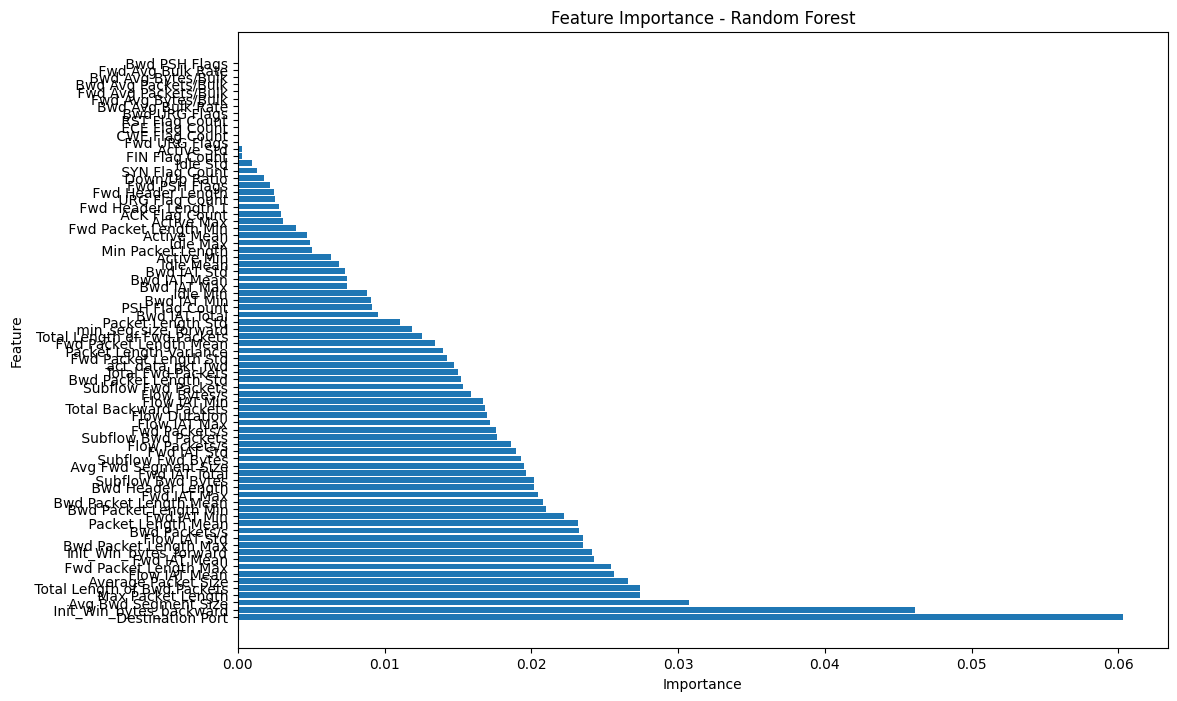

In [25]:
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [31]:
top_k = 20
top_features = feature_importance_df['Feature'][:top_k].values

X_train_selected = X_train_normalised[top_features]
X_test_selected = X_test_normalised[top_features]
print("Top 30 features selected for model training:")
print(top_features)

Top 30 features selected for model training:
[' Destination Port' ' Init_Win_bytes_backward' ' Avg Bwd Segment Size'
 ' Max Packet Length' ' Total Length of Bwd Packets'
 ' Average Packet Size' ' Flow IAT Mean' ' Fwd Packet Length Max'
 ' Fwd IAT Mean' 'Init_Win_bytes_forward' 'Bwd Packet Length Max'
 ' Flow IAT Std' ' Bwd Packets/s' ' Packet Length Mean' ' Fwd IAT Min'
 ' Bwd Packet Length Min' ' Bwd Packet Length Mean' ' Fwd IAT Max'
 ' Bwd Header Length' ' Subflow Bwd Bytes']


### Training Random Forest Model

In [27]:
'''
rf_model = RandomForestClassifier(
	n_estimators=200,
	random_state=42,
	n_jobs=-1
)

rf_model.fit(X_train_selected, y_train_resampled)

y_pred = rf_model.predict(X_test_selected)
'''

'\nrf_model = RandomForestClassifier(\n\tn_estimators=200,\n\trandom_state=42,\n\tn_jobs=-1\n)\n\nrf_model.fit(X_train_selected, y_train_resampled)\n\ny_pred = rf_model.predict(X_test_selected)\n'

### Training XG-Boost model

In [33]:
# GPU-ACCELERATED MODEL TRAINING
# This replaces RandomForest with XGBoost GPU for much faster training

import time
import xgboost as xgb
import numpy as np

print("=" * 70)
print("TRAINING GPU-ACCELERATED MODEL")
print("=" * 70)

try:
    print(f"\nDataset Information:")
    print(f"   Training samples: {X_train_selected.shape[0]:,}")
    print(f"   Features: {X_train_selected.shape[1]}")
    print(f"   Classes: {len(np.unique(y_train_resampled))}")
    
    print(f"\nInitializing XGBoost with GPU acceleration...")
    
    # XGBoost GPU classifier - MUCH faster than RandomForest
    rf_model = xgb.XGBClassifier(
        # GPU Configuration (XGBoost 3.1+ syntax)
        device='cuda:0',               # USE GPU - 'cuda:0' for first GPU, 'cuda:1' for second, etc.
        tree_method='hist',            # Use histogram-based algorithm (works with GPU)
        
        # Model Parameters (equivalent to RandomForest settings)
        n_estimators=200,              # Number of trees (same as your RF)
        random_state=42,
        
        # XGBoost-specific parameters for better performance
        learning_rate=0.1,             # Learning rate (lower = more conservative)
        max_depth=10,                  # Max tree depth (prevents overfitting)
        subsample=0.8,                 # Use 80% of data per tree (like bootstrap)
        colsample_bytree=0.8,          # Use 80% of features per tree
        min_child_weight=5,            # Minimum sum of instance weight in a child
        gamma=0.1,                     # Minimum loss reduction for split
        
        # Multi-class configuration
        objective='multi:softmax',     # Multi-class classification
        num_class=len(np.unique(y_train_resampled)),  # Number of classes
        
        # Performance settings
        n_jobs=-1,                     # Use all CPU cores for data loading
        verbosity=1,                   # Show progress (0=silent, 1=warning, 2=info)
        
        # Regularization (prevents overfitting)
        reg_alpha=0.1,                 # L1 regularization
        reg_lambda=1.0,                # L2 regularization
        
        # Other settings
        use_label_encoder=False,
        eval_metric='mlogloss'
    )
    
    print("\nStarting GPU training...")
    print("   (This should be 5-20x faster than CPU RandomForest)")
    
    t0 = time.time()
    rf_model.fit(
        X_train_selected, 
        y_train_resampled,
        verbose=True  # Show training progress
    )
    train_time = time.time() - t0
    
    print(f"\nTraining completed!")
    print(f"Time: {train_time:.2f} seconds ({train_time/60:.2f} minutes)")
    
    # Make predictions
    print(f"\nMaking predictions on test set...")
    t0 = time.time()
    y_pred = rf_model.predict(X_test_selected)
    pred_time = time.time() - t0
    
    print(f"Predictions completed!")
    print(f"Time: {pred_time:.2f} seconds")
    print(f"Total time: {train_time + pred_time:.2f} seconds")
    
    print("\n" + "=" * 70)
    print("GPU TRAINING SUCCESSFUL!")
    print("=" * 70)
    print("\nRun the next cell to see model performance metrics")
    print("   (Accuracy, Precision, Recall, F1 Score)")
    
except Exception as e:
    print("\n" + "=" * 70)
    print("GPU TRAINING FAILED - FALLING BACK TO CPU")
    print("=" * 70)
    print(f"\nError details: {str(e)}\n")
     
    print("\nUsing optimized CPU RandomForest as fallback...")

TRAINING GPU-ACCELERATED MODEL

Dataset Information:
   Training samples: 25,140,675
   Features: 20
   Classes: 15

Initializing XGBoost with GPU acceleration...

Starting GPU training...
   (This should be 5-20x faster than CPU RandomForest)

Starting GPU training...
   (This should be 5-20x faster than CPU RandomForest)


c:\Users\amos\Documents\50.020-Network-Security-Project\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:42:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Training completed!
Time: 262.02 seconds (4.37 minutes)

Making predictions on test set...
Predictions completed!
Time: 0.29 seconds
Total time: 262.31 seconds

GPU TRAINING SUCCESSFUL!

Run the next cell to see model performance metrics
   (Accuracy, Precision, Recall, F1 Score)
Predictions completed!
Time: 0.29 seconds
Total time: 262.31 seconds

GPU TRAINING SUCCESSFUL!

Run the next cell to see model performance metrics
   (Accuracy, Precision, Recall, F1 Score)


In [34]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.997871707394478
Precision: 0.8632622623490404
Recall: 0.892103943748706
F1 Score: 0.8677380657296273


In [35]:
with open("new_model.pkl", "wb") as f:
	pickle.dump(rf_model, f)
with open("scaler.pkl", "wb") as f:
	pickle.dump(scaler, f)
with open("feature_list.pkl", "wb") as f:
	pickle.dump(top_features, f)